# (3 of 3) LDA
---
# AMEX Default
# Dimensionality Reduction: PCA, LDA
### (For future use by Classification Algorithms)
---

In [1]:
import sys
sys.version

'3.8.8 (default, Apr 13 2021, 19:58:26) \n[GCC 7.3.0]'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_parquet('./dataset/train_data.parquet')

In [4]:
df['S_2'] = pd.to_datetime(df['S_2'], format='%Y/%m/%d')

In [5]:
category_cols = ['B_30','B_38','D_114','D_116','D_117','D_120','D_126','D_63','D_64','D_66','D_68']

for col in category_cols:
    df[col] = df[col].astype('category')

In [6]:
my_dictionary = {'CO':0,'CR':1,'CL':2,'XL':3,'XZ':4,'XM':5}
df['D_63'] = df['D_63'].map(my_dictionary)

In [7]:
my_dictionary = {'O':0,'R':1,'U':2,'-1':3}
df['D_64'] = df['D_64'].map(my_dictionary)

In [8]:
percent_missing = df.isnull().sum() * 100 / len(df)
df_missing_val = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

In [9]:
df.drop(
    columns=df_missing_val.loc[
        df_missing_val.percent_missing > 50
    ].index, inplace=True, errors='ignore'
)

In [10]:
df.dropna(inplace=True)

### Train/Test split with the 80:20 ratio

In [11]:
X = df.drop(['target','customer_ID','S_2'],axis=1)
y = df['target']

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1041295, 158)
(260324, 158)
(1041295,)
(260324,)


#### This evaluation function will collect the evaluation values for future use in performance graph comparison.

In [15]:
df_model_compare = pd.read_csv('./eval_results/eval_results_with_PCA.csv',index_col=0)

In [16]:
acc = df_model_compare.loc['Accuracy'].to_dict()
f1 = df_model_compare.loc['F1 Score'].to_dict()
prec = df_model_compare.loc['Precision'].to_dict()
recl = df_model_compare.loc['Recall'].to_dict()

def my_eval(model,y_test,predicted):
    
    print(model,'Results')
    print('Accuracy: ', accuracy_score(y_test, predicted))
    print('F1 Score: ', f1_score(y_test, predicted))
    print('Precision: ', precision_score(y_test, predicted))
    print('Recall: ', recall_score(y_test, predicted))
    
    acc[model] = accuracy_score(y_test, predicted)
    f1[model] = f1_score(y_test, predicted)
    prec[model] = precision_score(y_test, predicted)
    recl[model] = recall_score(y_test, predicted)
    
    global df_model_compare
    df_model_compare = pd.DataFrame.from_dict(
        [acc,f1,prec,recl]
    ).rename(
        index={0:'Accuracy',1:'F1 Score',2:'Precision',3:'Recall'}
    )
    display(df_model_compare)

---
# 1. Linear Discriminant Analysis (LDA)
---

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

With the limitation of this dataset that has only 2 classes, we can set the "n_components=1" only. Therefore, we can only visualize one dimension.

In [18]:
lda = LDA(n_components=1)
# n_components can't be larger than n-feature or n-class - 1

In [19]:
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

### LDA visualization

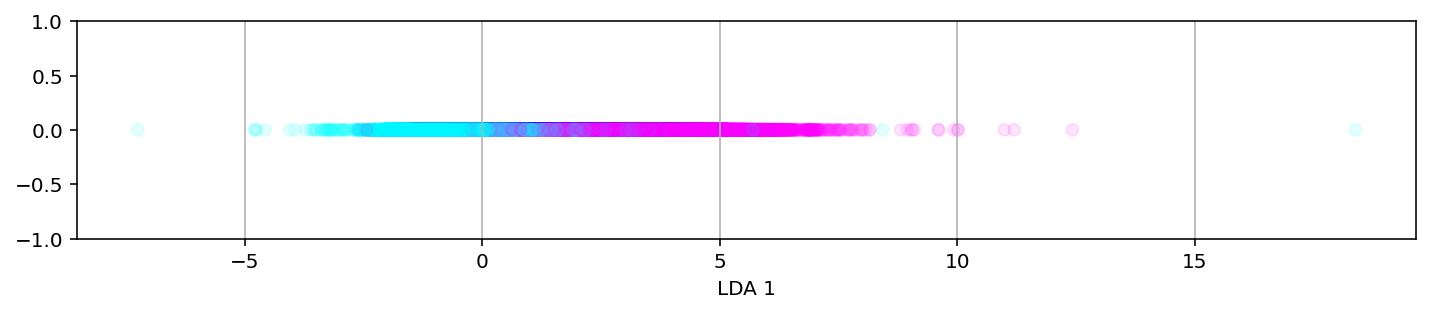

In [20]:
plt.figure(figsize=(12,2))
plt.scatter(X_train_lda[:,0],
            np.zeros(X_train_lda.size),
            c=y_train,cmap='cool', alpha=0.1)
plt.xlabel('LDA 1')
plt.ylim(-1,1)

plt.grid(axis='x')

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

## 1.1 Logistic Regression with LDA

In [22]:
from sklearn.linear_model import LogisticRegression

# max_iter=1000 same arg as the previous notebook, PCA
logistic_classifier_lda = LogisticRegression(max_iter=1000)
logistic_classifier_lda.fit(X_train_lda, y_train)

LogisticRegression(max_iter=1000)

Running time is approximately 1 second.

In [23]:
# Save Model
#joblib.dump(logistic_classifier_lda, './models/Logit_LDA.pkl')

# Load Model
logistic_classifier_lda = joblib.load('./models/Logit_LDA.pkl')

In [24]:
logistic_predicted_lda = logistic_classifier_lda.predict(X_test_lda)

In [25]:
confusion_matrix(y_test, logistic_predicted_lda)

array([[189665,  11669],
       [ 17518,  41472]])

[ TN FP ]  
[ FN TP ]

TP (Predict as default; the truth is default)  
TN (Predict as not default; the truth is not default)  
FP (Predict as default; the truth is not default)  
FN (Predict as not default; the truth is default)

In [26]:
my_eval('Logit_LDA',y_test,logistic_predicted_lda)

Logit_LDA Results
Accuracy:  0.8878820239393986
F1 Score:  0.7397062364555742
Precision:  0.7804143693193579
Recall:  0.7030344126123071


,Logit,NB,DT,RF,Logit_PCA,NB_PCA,DT_PCA,RF_PCA,Logit_LDA
Accuracy,0.890152,0.860389,0.862033,0.908353,0.880426,0.837864,0.859341,0.911791,0.887882
F1 Score,0.750402,0.706927,0.695627,0.795428,0.723665,0.556518,0.690701,0.800681,0.739706
Precision,0.773436,0.674146,0.695509,0.804785,0.759635,0.731898,0.688334,0.820428,0.780414
Recall,0.728700,0.743058,0.695745,0.786286,0.690948,0.448940,0.693084,0.781861,0.703034


## 1.2 Naive Bayes with LDA

In [27]:
from sklearn.naive_bayes import GaussianNB

nb_lda = GaussianNB()
nb_lda.fit(X_train_lda, y_train)

GaussianNB()

Running time is approximately 1 second.

In [28]:
# Save Model
#joblib.dump(nb_lda, './models/NB_LDA.pkl')

# Load Model
nb_lda = joblib.load('./models/NB_LDA.pkl')

In [29]:
nb_predicted_lda = nb_lda.predict(X_test_lda)

In [30]:
confusion_matrix(y_test, nb_predicted_lda)

array([[187702,  13632],
       [ 15297,  43693]])

In [31]:
my_eval('NB_LDA',y_test,nb_predicted_lda)

NB_LDA Results
Accuracy:  0.8888730966026951
F1 Score:  0.7512874521772772
Precision:  0.7621979938944614
Recall:  0.74068486184099


,Logit,NB,DT,RF,Logit_PCA,NB_PCA,DT_PCA,RF_PCA,Logit_LDA,NB_LDA
Accuracy,0.890152,0.860389,0.862033,0.908353,0.880426,0.837864,0.859341,0.911791,0.887882,0.888873
F1 Score,0.750402,0.706927,0.695627,0.795428,0.723665,0.556518,0.690701,0.800681,0.739706,0.751287
Precision,0.773436,0.674146,0.695509,0.804785,0.759635,0.731898,0.688334,0.820428,0.780414,0.762198
Recall,0.728700,0.743058,0.695745,0.786286,0.690948,0.448940,0.693084,0.781861,0.703034,0.740685


## 1.3 Decision Tree with LDA

In [32]:
from sklearn.tree import DecisionTreeClassifier

dtree_lda = DecisionTreeClassifier()
dtree_lda.fit(X_train_lda, y_train)

DecisionTreeClassifier()

Running time is approximately 8 seconds.

In [33]:
# Save Model
#joblib.dump(dtree_lda, './models/DT_LDA.pkl')

# Load Model
dtree_lda = joblib.load('./models/DT_LDA.pkl')

In [34]:
dtree_predicted_lda = dtree_lda.predict(X_test_lda)

In [35]:
confusion_matrix(y_test, dtree_predicted_lda)

array([[181329,  20005],
       [ 20394,  38596]])

In [36]:
my_eval('DT_LDA',y_test,dtree_predicted_lda)

DT_LDA Results
Accuracy:  0.8448126181220326
F1 Score:  0.656444795945268
Precision:  0.6586235729765704
Recall:  0.6542803865061875


,Logit,NB,DT,RF,Logit_PCA,NB_PCA,DT_PCA,RF_PCA,Logit_LDA,NB_LDA,DT_LDA
Accuracy,0.890152,0.860389,0.862033,0.908353,0.880426,0.837864,0.859341,0.911791,0.887882,0.888873,0.844813
F1 Score,0.750402,0.706927,0.695627,0.795428,0.723665,0.556518,0.690701,0.800681,0.739706,0.751287,0.656445
Precision,0.773436,0.674146,0.695509,0.804785,0.759635,0.731898,0.688334,0.820428,0.780414,0.762198,0.658624
Recall,0.728700,0.743058,0.695745,0.786286,0.690948,0.448940,0.693084,0.781861,0.703034,0.740685,0.654280


## 1.4 Random Forest with LDA

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_lda = RandomForestClassifier()
rf_lda.fit(X_train_lda, y_train)

Running time is approximately 8 minutes.

In [37]:
# Save Model
#joblib.dump(rf_lda, './models/RF_LDA.pkl')

# Load Model
rf_lda = joblib.load('./models/RF_LDA.pkl')

In [38]:
rf_predicted_lda = rf_lda.predict(X_test_lda)

In [39]:
confusion_matrix(y_test, rf_predicted_lda)

array([[181206,  20128],
       [ 20219,  38771]])

In [40]:
my_eval('RF_LDA',y_test,rf_predicted_lda)

RF_LDA Results
Accuracy:  0.8450123692014566
F1 Score:  0.6577543282240074
Precision:  0.6582624492775768
Recall:  0.6572469910154264


,Logit,NB,DT,RF,Logit_PCA,NB_PCA,DT_PCA,RF_PCA,Logit_LDA,NB_LDA,DT_LDA,RF_LDA
Accuracy,0.890152,0.860389,0.862033,0.908353,0.880426,0.837864,0.859341,0.911791,0.887882,0.888873,0.844813,0.845012
F1 Score,0.750402,0.706927,0.695627,0.795428,0.723665,0.556518,0.690701,0.800681,0.739706,0.751287,0.656445,0.657754
Precision,0.773436,0.674146,0.695509,0.804785,0.759635,0.731898,0.688334,0.820428,0.780414,0.762198,0.658624,0.658262
Recall,0.728700,0.743058,0.695745,0.786286,0.690948,0.448940,0.693084,0.781861,0.703034,0.740685,0.654280,0.657247


---
# 2. Performance Graph Comparison
---

In [41]:
df_model_compare.to_csv('./eval_results/eval_results_with_PCA_LDA.csv')

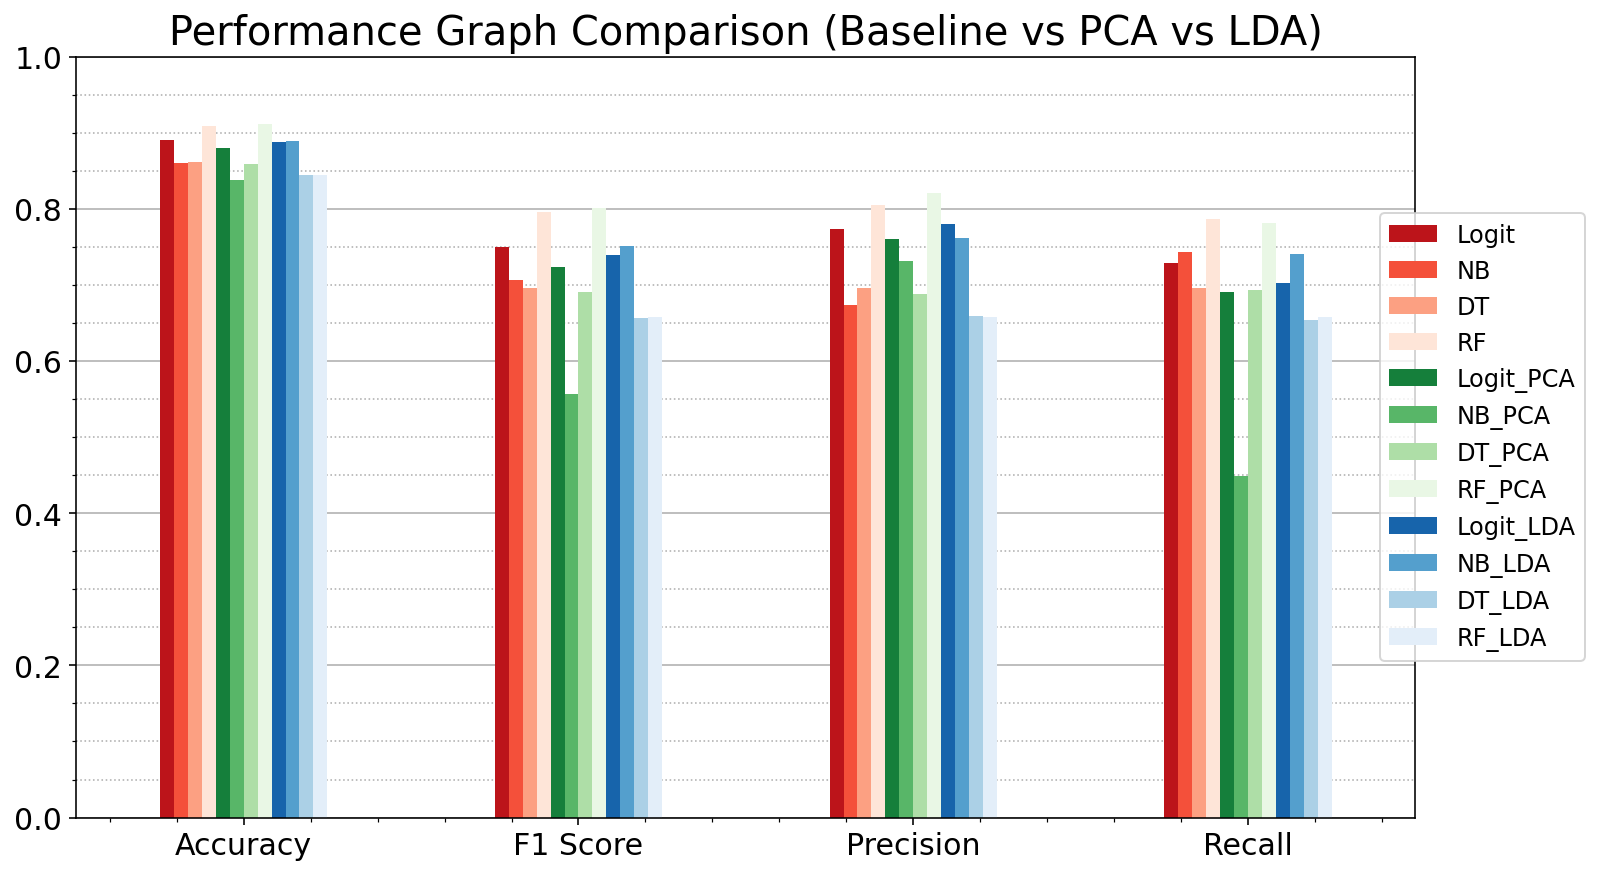

In [42]:
cmap1 = plt.cm.Reds
cmap2 = plt.cm.Greens
cmap3 = plt.cm.Blues
colors = [*cmap1(np.linspace(.8, .1, 4)),
          *cmap2(np.linspace(.8, .1, 4)),
          *cmap3(np.linspace(.8, .1, 4))]


ax = df_model_compare.plot(
    kind='bar', color=colors, rot=0,
    ylim=(0,1), figsize = (12,7), fontsize=15
)
ax.set_axisbelow(True)
ax.grid(linestyle='-', axis='y')
ax.legend(fontsize=12, loc='center', bbox_to_anchor=(1.05,0.5))

plt.minorticks_on()
plt.grid(which='minor', axis='y',ls=':')
plt.title('Performance Graph Comparison (Baseline vs PCA vs LDA)', fontsize=20)
plt.savefig('./img/graph_PCA_LDA')
plt.show()

After the LDA was performed, the performance did not differ greatly from the PCA.  

In general, the LDA tends to give better performance since it uses "y_train" when creating the components. (If we use LDA with another dataset, the LDA might provide better performance than the PCA.)

In [43]:
columns = ['Logit','NB','DT','RF']
rows = ['Baseline','PCA (n=30)','LDA (n=1)']
values = [[5,0.08,20,60],[0.33,0.02,2,25],[0.01,0.01,0.08,8]]

df_running_time = pd.DataFrame(values,rows,columns)

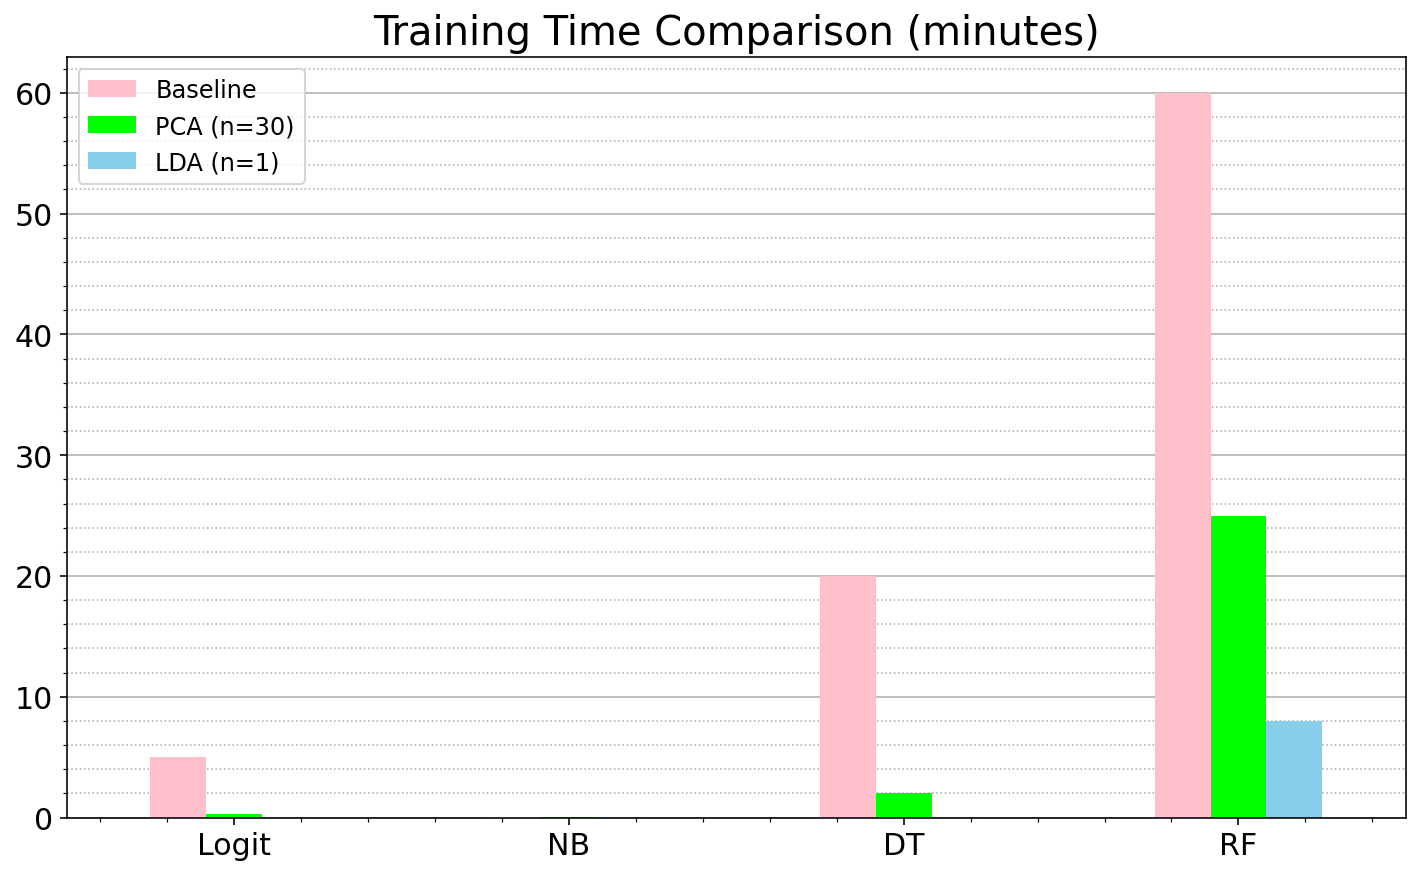

In [44]:
ax = df_running_time.T.plot(
    kind='bar', color=['pink','lime','skyblue'], rot=0,
    figsize = (12,7), fontsize=15
)
ax.set_axisbelow(True)
ax.grid(linestyle='-', axis='y')
ax.legend(fontsize=12)

plt.minorticks_on()
plt.grid(which='minor', axis='y',ls=':')
plt.title('Training Time Comparison (minutes)', fontsize=20)
plt.savefig('./img/running_time_PCA_LDA')
plt.show()

Running on Intel Core i5-8250U 1.8GHz 4 cores 8 threads

---
# Thank You